In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/PAC/cnn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/PAC/cnn


In [ ]:
%cd ..

C:\Users\Cliente\Documents\PAC\cnn


In [188]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.gridspec as gridspec
from skimage.transform import rotate
from celluloid import Camera
from src import data
from src import visualize as vs
from scipy import stats

In [3]:
def FFT(x):
    return np.abs(np.fft.fft(x))

def Cxx(x):
    return np.correlate(x, x, mode='same')

def PSD(x):
    return FFT(Cxx(x))

Escala verdadeira: 0.0618 mm/píxel


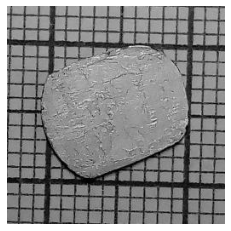

In [295]:
img, G, areas = data.load_random(get_area=True, grayscale=True)
true_freq = np.sqrt(areas[0]/np.sum(G))
print(f'Escala verdadeira: {true_freq:.4f} mm/píxel')

I = img[0, :, :, 0].numpy()
vs.plot_image(img, cmap='gray')

In [296]:
freqs = np.fft.fftfreq(img.shape[1])
loc = freqs > 0
freqs.shape

(256,)

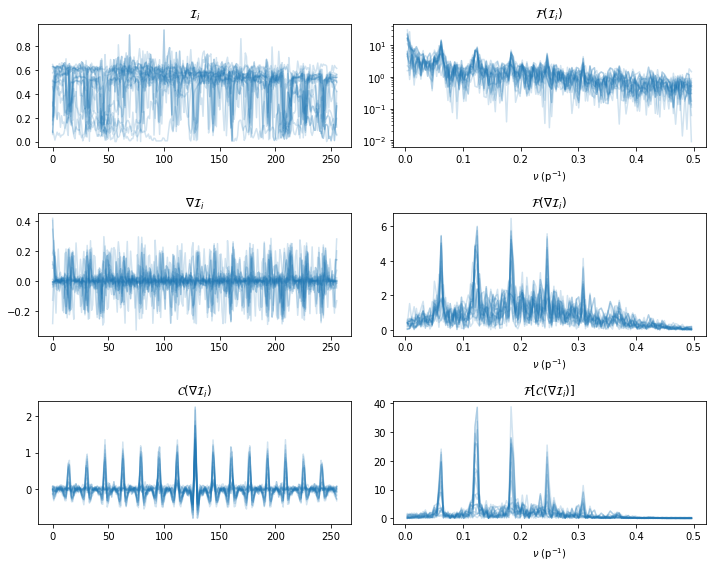

In [334]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

axs[0, 0].set_title(r'$\mathcal{I}_i$')
axs[0, 1].set_title(r'$\mathcal{F}(\mathcal{I}_i)$')
axs[1, 0].set_title(r'$\nabla \mathcal{I}_i$')
axs[1, 1].set_title(r'$\mathcal{F}(\nabla \mathcal{I}_i)$')
axs[2, 0].set_title(r'$\mathcal{C}(\nabla \mathcal{I}_i)$')
axs[2, 1].set_title(r'$\mathcal{F}[\mathcal{C}(\nabla \mathcal{I}_i)]$')

Iy = np.gradient(I)[1]
for i in np.random.randint(0, I.shape[0], 20):
    axs[0, 0].plot(I[i], 'C0-', alpha=0.2)
    axs[0, 1].semilogy(freqs[loc], FFT(I[i])[loc], 'C0-', alpha=0.2)
    axs[1, 0].plot(Iy[i], 'C0-', alpha=0.2)
    axs[1, 1].plot(freqs[loc], FFT(Iy[i])[loc], 'C0-', alpha=0.2)
    axs[2, 0].plot(Cxx(Iy[i]), 'C0-', alpha=0.2)
    axs[2, 1].plot(freqs[loc], FFT(Cxx(Iy[i]))[loc], 'C0-', alpha=0.2)

for ax in axs[:, 1]: ax.set_xlabel(r'$\nu$ (p$^{-1}$)')
fig.tight_layout()
plt.show()

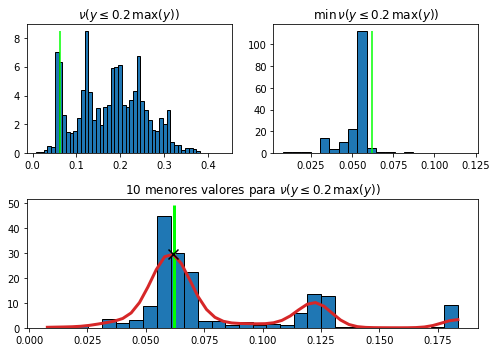

Moda: 0.061623086734693876
Erro: 0.36%


In [340]:
T1 = 0.2
T2 = 10

I = img[0, :, :, 0].numpy()
I = np.concatenate((I, I.T))
Iy = np.gradient(I)[1]
F = map(lambda x: FFT(Cxx(x)), Iy)
th = list(map(lambda y: np.abs(freqs[y > T1*y.max()]), F))

fig = plt.figure(figsize=(7, 5))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title(r'$\nu(y \leq {}\,\max(y))$'.format(T1))
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title(r'$\min\,\nu(y \leq {}\,\max(y))$'.format(T1))
ax3 = fig.add_subplot(gs[1, :])
ax3.set_title(r'{} menores valores para $\nu(y \leq {}\,\max(y))$'.format(T2, T1))
fig.tight_layout()

h, _, _ = ax1.hist(np.concatenate(th), bins=50, edgecolor='k', density=True)
ax1.vlines(true_freq, h.min(), h.max(), color='lime')
h, bins, _ = ax2.hist(list(map(np.min, th)), bins=20, edgecolor='k', density=True)
ax2.vlines(true_freq, h.min(), h.max(), color='lime')

D = np.concatenate(list(map(lambda arr: np.sort(arr)[:T2], th)))
kernel = stats.gaussian_kde(D)

h, bins, _ = ax3.hist(D, bins=30, density=True, edgecolor='k')
x = np.linspace(bins.min(), bins.max(), 50)
f = kernel(x)
pred_freq = x[f == f.max()][0]

ax3.plot(x, f, 'C3-', lw=3)
ax3.vlines(true_freq, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
ax3.scatter(pred_freq, f.max(), marker='x', c='k', zorder=4, s=100)

plt.show()
print(
    'Moda: %s'%pred_freq,
    f'Erro: {(np.abs(true_freq - pred_freq)/true_freq*100):.2f}%',
    sep='\n'
)

# Detecção da inclinação

In [303]:
angle = 40

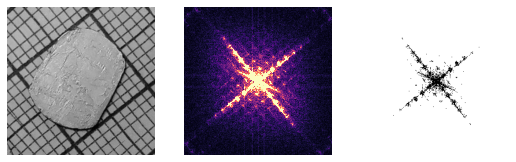

In [308]:
T3 = 25e-4

fig = plt.figure(figsize=(9, 3))

I = rotate(img[0, :, :, 0].numpy(), angle, mode='reflect')
fft2d = np.abs(np.fft.fftshift(np.fft.fft2(I)))
L = fft2d > fft2d.max()*T3

fig.add_subplot(131)
vs.plot_image(I, cmap='gray')

fig.add_subplot(132)
vs.plot_image(fft2d, cmap='magma', vmax=fft2d.max()*T3)

fig.add_subplot(133)
vs.plot_image(L, cmap='binary')

plt.show()

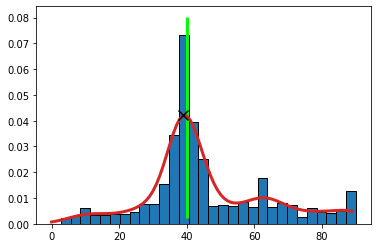

Moda: 39
Erro: 2.50%


In [318]:
X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90

kernel = stats.gaussian_kde(H)

h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k')
x = np.arange(0, 90)
f = kernel(x)
pred_angle = x[f == f.max()][0]

plt.plot(x, f, 'C3-', lw=3)
plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
plt.scatter(pred_angle, f.max(), marker='x', c='k', zorder=4, s=100)
plt.show()
print(
    'Moda: %s'%pred_angle,
    f'Erro: {(np.abs(angle - pred_angle)/angle*100):.2f}%',
    sep='\n'
)

In [316]:
def find_slope(img, t=25e-4):
    fft2d = np.abs(np.fft.fftshift(np.fft.fft2(img)))
    L = fft2d > fft2d.max()*t
    X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    kernel = stats.gaussian_kde(H)
    x = np.arange(0, 90)
    f = kernel(x)
    return x[f == f.max()]

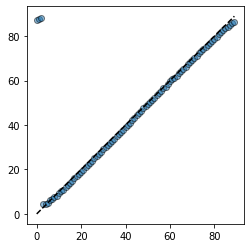

In [317]:
At = np.arange(90)
A = [find_slope(rotate(img[0, :, :, 0].numpy(), a, mode='reflect')) for a in At]

fig, ax = plt.subplots()
ax.scatter(At, A, alpha=0.5, edgecolor='k')
ax.plot(At, At, 'k--')
ax.set_aspect('equal')
plt.show()

In [196]:
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2:])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xlabel('inclinação')
fig.tight_layout()

camera = Camera(fig)
for angle in range(90):
    I = rotate(img[0, :, :, 0].numpy(), angle, mode='reflect')
    fft2d = np.abs(np.fft.fftshift(np.fft.fft2(I)))
    L = fft2d > fft2d.max()*25e-4
    X, Y = np.meshgrid(*[np.fft.fftshift(freqs)]*2)
    H = 90 - np.degrees(np.arctan2(Y[L], X[L]))%90
    
    ax1.imshow(I, cmap='gray')
    ax2.imshow(fft2d, cmap='magma', vmax=fft2d.max()*25e-4)

    h, bins, _ = plt.hist(H, bins=30, density=True, edgecolor='k', alpha=0.7, color='C0')
    x = np.linspace(bins.min(), bins.max(), 100)
    kernel = stats.gaussian_kde(H)
    f = kernel(x)
    pred_angle = x[f == f.max()][0]

    plt.plot(x, f, 'C3-', lw=3)
    plt.vlines(angle, h.min(), h.max() + h.ptp()*0.1, color='lime', lw=3)
    plt.scatter(pred_angle, f.max(), marker='x', c='k', zorder=4, s=100)

    camera.snap()

animation = camera.animate()
animation.save('reports/figures/slope_detection.gif', writer=PillowWriter(fps=10))
plt.close()

![](../reports/figures/slope_detection.gif)